Basis functions

In [133]:
import os
import shapely
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [134]:
grid_gdf = gpd.read_file("grid_pts_coarse.shp")

<AxesSubplot:>

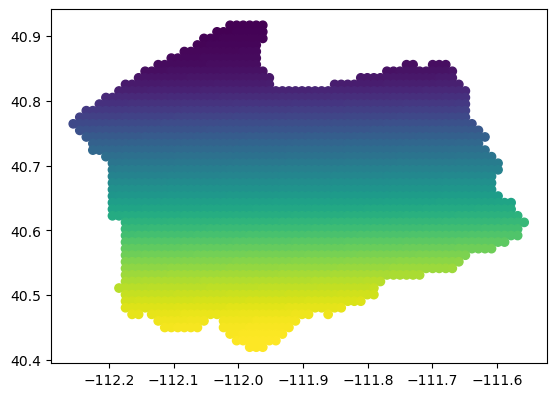

In [135]:
grid_gdf.plot(column = "rstr_c_")

In [136]:
grid_crds = grid_gdf.get_coordinates()
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)

-112.25516635714284 -111.55831564285714 40.419293290000006 40.916769710000004


In [137]:
grid_crds['normalized_lon'] = (grid_crds['x']-min_x)/(max_x - min_x)
grid_crds['normalized_lat'] = (grid_crds['y']-min_y)/(max_y-min_y)

## Stationary monitor data

In [138]:
aq_df = pd.read_csv("data/ozone_data.csv")
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
0,2005,40.598056,-111.894167,Ozone,2023-07-01T00:00:00Z,2023-07-01,0S,0.033
1,2005,40.598056,-111.894167,Ozone,2023-07-01T01:00:00Z,2023-07-01,1H 0M 0S,0.033
2,2005,40.598056,-111.894167,Ozone,2023-07-01T02:00:00Z,2023-07-01,2H 0M 0S,0.031
3,2005,40.598056,-111.894167,Ozone,2023-07-01T03:00:00Z,2023-07-01,3H 0M 0S,0.023
4,2005,40.598056,-111.894167,Ozone,2023-07-01T04:00:00Z,2023-07-01,4H 0M 0S,0.021


In [139]:
aq_df['day_time'] = pd.to_datetime(aq_df['day_time'])
# add the timezone:
aq_df['day_time'] = aq_df['day_time'] + pd.Timedelta(hours=7)

print(aq_df['day_time'][0:10])
print(aq_df['day_time'].dtype)

0   2023-07-01 07:00:00+00:00
1   2023-07-01 08:00:00+00:00
2   2023-07-01 09:00:00+00:00
3   2023-07-01 10:00:00+00:00
4   2023-07-01 11:00:00+00:00
5   2023-07-01 12:00:00+00:00
6   2023-07-01 13:00:00+00:00
7   2023-07-01 14:00:00+00:00
8   2023-07-01 15:00:00+00:00
9   2023-07-01 16:00:00+00:00
Name: day_time, dtype: datetime64[ns, UTC]
datetime64[ns, UTC]


In [140]:
aq_df = aq_df[(aq_df.day_time >= "2023-07-07") & (aq_df.day_time <= "2023-07-21")]

In [141]:
lon = aq_df.values[:,2].astype('float64')
lat = aq_df.values[:,1].astype('float64')
aq_df['normalized_lon'] = (lon-min_x)/(max_x - min_x)
aq_df['normalized_lat'] = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]

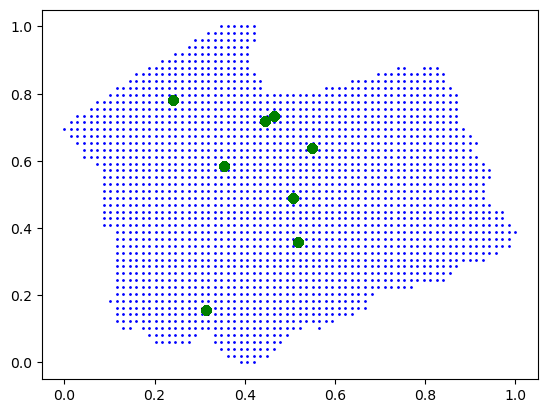

In [142]:
plt.plot(grid_crds['normalized_lon'], grid_crds['normalized_lat'], 'bo', markersize=1)
plt.plot(aq_df['normalized_lon'], aq_df['normalized_lat'], 'go')
plt.show()

## Standarizing time

In [143]:
aq_df.head()

day_time = aq_df['day_time'].astype('int64') / 1e9 ## Time in nanoseconds

min_t = day_time.min()
max_t = day_time.max()
print(min_t, max_t)

aq_df['normalized_time'] = (day_time - min_t) / (max_t-min_t)
aq_df['normalized_time']


1688688000.0 1689897600.0


/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_3403/1457317794.py:3: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  day_time = aq_df['day_time'].astype('int64') / 1e9 ## Time in nanoseconds


137     0.000000
138     0.002976
139     0.005952
140     0.008929
141     0.011905
          ...   
5435    0.988095
5436    0.991071
5437    0.994048
5438    0.997024
5439    1.000000
Name: normalized_time, Length: 2677, dtype: float64

## mobile data

In [144]:
ebus = pd.read_csv("data/ebus_min_2023_07.csv", header = [0,1],
                   na_values = -9999.00) # note: -9999.00 isn't a value in level 2 mobile data
ebus.head()
print(ebus.shape)

trax = pd.read_csv("data/trx_min_2023_07.csv", header = [0, 1],
                   na_values = -9999.00)
trax.head()
trax.shape

(79195, 20)


(93463, 16)

In [145]:
ebus = pd.DataFrame({
    'time': pd.to_datetime(ebus.iloc[:,0]),
    'lon': ebus.iloc[:,2],
    'lat': ebus.iloc[:,1],
    'o3': ebus.iloc[:,15]
    })
trax = pd.DataFrame({
    'time': pd.to_datetime(trax.iloc[:,0]),
    'lon': trax.iloc[:,2],
    'lat': trax.iloc[:,1],
    'o3': trax.iloc[:,15]
    })

trax[trax.o3 == 0].count()
ebus[ebus.o3 == 0].count()

trax = trax[trax.o3 != 0] # no pm25 observations should be zero

In [146]:
mobile = ebus 
#pd.concat([ebus, trax])
mobile.shape

(79195, 4)

In [147]:
mobile['val'] = mobile['o3'] / 1000 # the mobile and aqs units are different for ozone
mobile = mobile.drop(["o3"], axis = 1)

mobile.head()

,time,lon,lat,val
0,2023-07-01 00:00:00,-111.97723,40.70350,0.0573
1,2023-07-01 00:00:00,-111.96915,40.69294,0.0604
2,2023-07-01 00:00:00,-111.96718,40.69298,0.0578
3,2023-07-01 00:01:00,-111.97723,40.70347,0.0525
4,2023-07-01 00:01:00,-111.97194,40.69294,0.0610


In [148]:
#print(ebus["pm25"].value_counts())
#trax["pm25"].value_counts()

In [149]:
# crop time, 1wk +/- July 13
mobile = mobile[(mobile.time >= "2023-07-07") & (mobile.time <= "2023-07-20 23:00:00")].copy()
mobile.shape

(37384, 4)

## Standarizing coordinates

In [150]:
mobile['normalized_lon'] = (mobile['lon'] - min_x)/(max_x - min_x)
mobile['normalized_lat'] = (mobile['lat'] - min_y)/(max_y - min_y)

mobile

,time,lon,lat,val,normalized_lon,normalized_lat
20359,2023-07-07 00:00:00,-111.96713,40.69299,0.0563,0.413340,0.550170
20360,2023-07-07 00:00:00,-111.96859,40.69295,0.0530,0.411245,0.550090
20361,2023-07-07 00:01:00,-111.97102,40.69295,0.0600,0.407758,0.550090
20362,2023-07-07 00:01:00,-111.97615,40.69294,0.0566,0.400396,0.550070
20363,2023-07-07 00:02:00,-111.97708,40.69617,0.0526,0.399062,0.556562
...,...,...,...,...,...,...
57738,2023-07-20 22:58:00,-111.97121,40.69293,0.0642,0.407485,0.550050
57739,2023-07-20 22:59:00,-111.97706,40.69463,0.0678,0.399090,0.553467
57740,2023-07-20 22:59:00,-111.90945,40.76352,0.0748,0.496113,0.691946
57741,2023-07-20 23:00:00,-111.97706,40.69622,0.0648,0.399090,0.556663


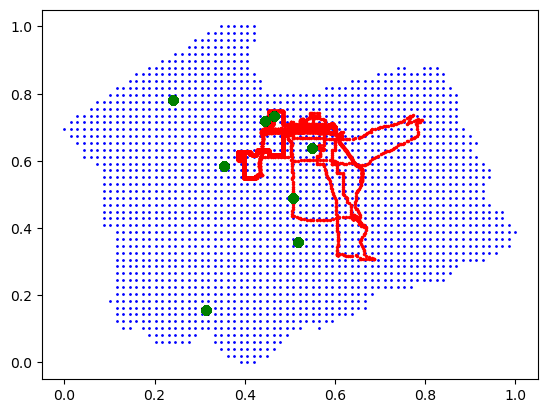

In [151]:
plt.plot(grid_crds['normalized_lon'], grid_crds['normalized_lat'], 'bo', markersize=1)
plt.plot(mobile['normalized_lon'], mobile['normalized_lat'], 'ro', markersize = 1.5)
plt.plot(aq_df['normalized_lon'], aq_df['normalized_lat'], 'go')
plt.show()

## Standardizing time

In [152]:
day_time = mobile['time'].astype('int64') / 1e9 ## Time in nanoseconds
mobile['normalized_time'] = (day_time - min_t) / (max_t-min_t)
mobile['normalized_time']

/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_3403/979023276.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  day_time = mobile['time'].astype('int64') / 1e9 ## Time in nanoseconds


20359    0.000000
20360    0.000000
20361    0.000050
20362    0.000050
20363    0.000099
           ...   
57738    0.996925
57739    0.996974
57740    0.996974
57741    0.997024
57742    0.997024
Name: normalized_time, Length: 37384, dtype: float64

## Basis functions

In [153]:
# time basis
num_basis = [10, 20, 56] # 3 layers with n knots per layer
std_arr = [0.3, 0.15, 0.05] # sd for gaussian function

mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

mu_knots # ragged array

[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([0.        , 0.01818182, 0.03636364, 0.05454545, 0.07272727,
        0.09090909, 0.10909091, 0.12727273, 0.14545455, 0.16363636,
        0.18181818, 0.2       , 0.21818182, 0.23636364, 0.25454545,
        0.27272727, 0.29090909, 0.30909091, 0.32727273, 0.34545455,
        0.36363636, 0.38181818, 0.4       , 0.41818182, 0.43636364,
        0.45454545, 0.47272727, 0.49090909, 0.50909091, 0.52727273,
        0.54545455, 0.56363636, 0.58181818, 0.6       , 0.61818182,
        0.63636364, 0.65454545, 0.67272727, 0.69090909, 0.70909091,
        0.72727273, 0.74545455, 0.76363636, 

In [154]:
s = np.array(aq_df['normalized_time']).reshape(len(aq_df),1)
print(s.shape)
N_data = len(aq_df)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(2677, 1)
2677


In [155]:
phi_t1 = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)): # loop through each basis layer
    std = std_arr[res]
    for i in range(num_basis[res]): # loop through each knot in the layer
        d = np.square(np.absolute(s - mu_knots[res][i])) # distance from each obs in s to knot
        for j in range(len(d)): # estimate gaussian weight
            if d[j] >= 0 and d[j] <= 1:
                phi_t1[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t1[j,i + K] = 0
    K = K + num_basis[res]

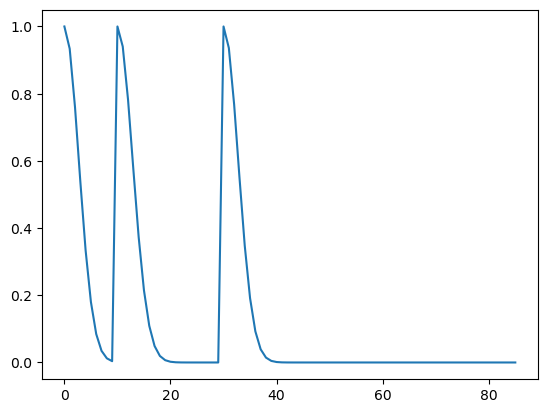

In [156]:
plt.plot(phi_t1[0,:])

## mobile data

In [157]:
s = np.array(mobile['normalized_time']).reshape(len(mobile),1)
print(s.shape)
N_data = len(mobile)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(37384, 1)
37384


In [158]:
phi_t2 = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)): # loop through each basis layer
    std = std_arr[res]
    for i in range(num_basis[res]): # loop through each knot in the layer
        d = np.square(np.absolute(s - mu_knots[res][i])) # distance from each obs in s to knot
        for j in range(len(d)): # estimate gaussian weight
            if d[j] >= 0 and d[j] <= 1:
                phi_t2[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t2[j,i + K] = 0
    K = K + num_basis[res]

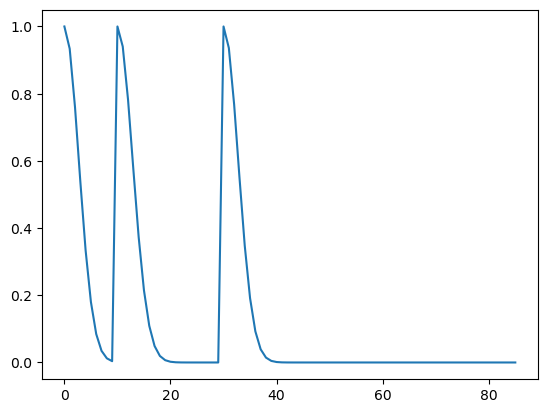

In [159]:
plt.plot(phi_t2[0,:])

In [160]:
# space basis

## Knots for spatial dimension (from STDK example)
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]

knots_1d

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]

## monitor data

In [161]:
## Make array of coordinates
s = np.vstack((aq_df['normalized_lon'],aq_df['normalized_lat'])).T
N = len(aq_df)

In [162]:
## Get weights from Wendland kernel
K = 0
phi_s1 = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s1[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi_s1[j,i + K] = 0
    K = K + num_basis[res]

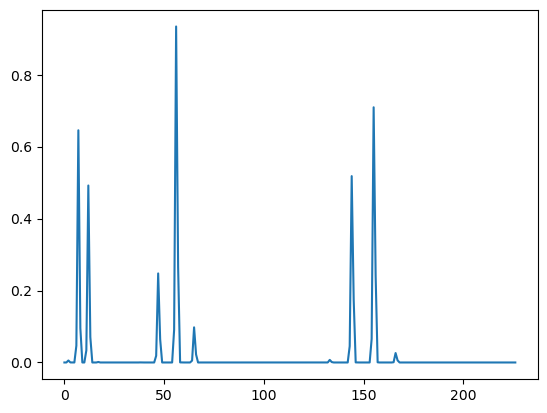

In [163]:
plt.plot(phi_s1[0,:]) # basis function for first location

In [164]:
x = phi_s1[0,0:25]
x = x.reshape(5, 5)

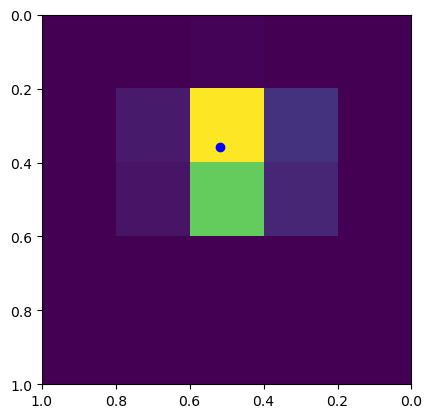

In [165]:
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()

In [166]:
num_basis

[25, 81, 121]

In [187]:
x = phi_s1[0,25:106]
x = x.reshape(9, 9)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()


ValueError: cannot reshape array of size 96 into shape (9,9)

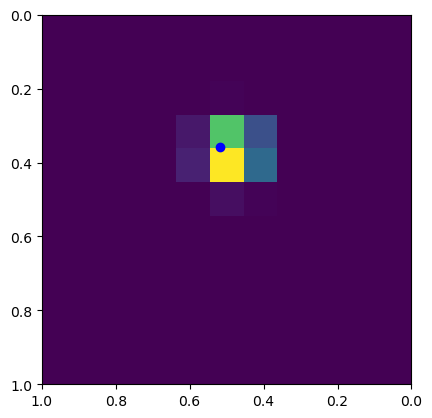

In [168]:
x = phi_s1[0,106:227]
x = x.reshape(11, 11)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()


## mobile data

In [169]:
## Make array of coordinates
s = np.vstack((mobile['normalized_lon'],mobile['normalized_lat'])).T
N = len(mobile)

In [170]:
## Get weights from Wendland kernel
K = 0
phi_s2 = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s2[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi_s2[j,i + K] = 0
    K = K + num_basis[res]

## output: cleaning and storing

In [171]:
# monitors

print(phi_t1.shape)
print(phi_s1.shape)

phi_1 = np.hstack((phi_t1,phi_s1)) # bind columns

(2677, 86)
(2677, 227)


In [172]:
idx_zero = np.array([], dtype=int)
for i in range(phi_1.shape[1]):
    if sum(phi_1[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i)) # remove 0s (basis not linked to obs)

phi_1_reduce = np.delete(phi_1,idx_zero,1)
print(phi_1.shape)
print(phi_1_reduce.shape)

(2677, 313)
(2677, 217)


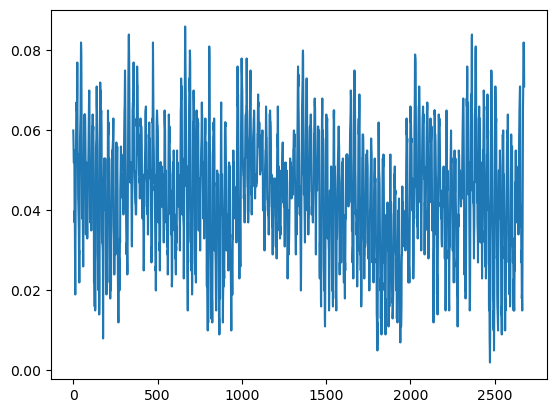

In [173]:
y = np.array(aq_df["sample.measurement"])
df_y = pd.DataFrame(y)
plt.plot(y) # note pm25 has more extremes than ozone; may be weekends in July? 

In [174]:
df = pd.DataFrame(phi_1)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df['normalized_time'] = aq_df['normalized_time'].to_numpy()
df.to_csv("rbfs/phi_1_o3_full.csv")
df = pd.DataFrame(phi_1_reduce)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df['normalized_time'] = aq_df['normalized_time'].to_numpy()
df.to_csv("rbfs/phi_1_o3_reduce.csv")

In [175]:
# mobile

print(phi_t2.shape)
print(phi_s2.shape)

phi_2 = np.hstack((phi_t2, phi_s2))

(37384, 86)
(37384, 227)


In [176]:
idx_zero = np.array([], dtype=int)
for i in range(phi_2.shape[1]):
    if sum(phi_2[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_2_reduce = np.delete(phi_2,idx_zero,1)
print(phi_2.shape)
print(phi_2_reduce.shape)

(37384, 313)
(37384, 214)


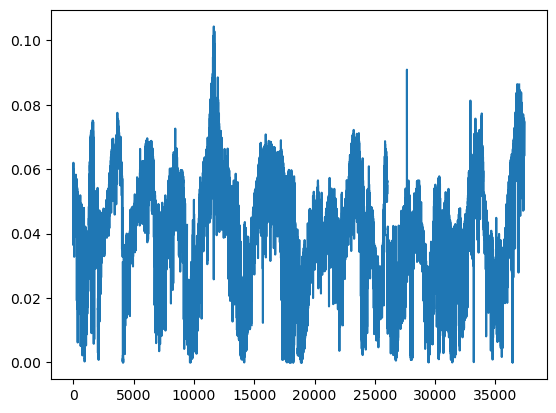

In [177]:
y = np.array(mobile["val"])
df_y = pd.DataFrame(y)
plt.plot(y)

In [178]:
mobile

,time,lon,lat,val,normalized_lon,normalized_lat,normalized_time
20359,2023-07-07 00:00:00,-111.96713,40.69299,0.0563,0.413340,0.550170,0.000000
20360,2023-07-07 00:00:00,-111.96859,40.69295,0.0530,0.411245,0.550090,0.000000
20361,2023-07-07 00:01:00,-111.97102,40.69295,0.0600,0.407758,0.550090,0.000050
20362,2023-07-07 00:01:00,-111.97615,40.69294,0.0566,0.400396,0.550070,0.000050
20363,2023-07-07 00:02:00,-111.97708,40.69617,0.0526,0.399062,0.556562,0.000099
...,...,...,...,...,...,...,...
57738,2023-07-20 22:58:00,-111.97121,40.69293,0.0642,0.407485,0.550050,0.996925
57739,2023-07-20 22:59:00,-111.97706,40.69463,0.0678,0.399090,0.553467,0.996974
57740,2023-07-20 22:59:00,-111.90945,40.76352,0.0748,0.496113,0.691946,0.996974
57741,2023-07-20 23:00:00,-111.97706,40.69622,0.0648,0.399090,0.556663,0.997024


In [179]:
df = pd.DataFrame(phi_2)
df['y'] = df_y[0]
df['date'] = mobile['time'].to_numpy()
df['normalized_time'] = mobile['normalized_time'].to_numpy()
df.to_csv("rbfs/phi_2_o3_full.csv")
df = pd.DataFrame(phi_2_reduce)
df['y'] = df_y[0]
df['date'] = mobile['time'].to_numpy()
df['normalized_time'] = mobile['normalized_time'].to_numpy()
df.to_csv("rbfs/phi_2_o3_reduce.csv")

In [180]:
df['lat'] = mobile['lat'].to_numpy()
df['lon'] = mobile['lon'].to_numpy()
df.to_csv("rbfs/phi_2_o3_reduce_crds.csv")

In [181]:
df.shape

(37384, 219)

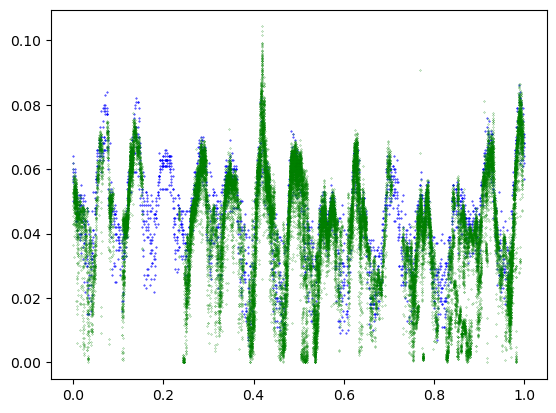

In [182]:
df3 = df[df['y'] < 40] 
aq_df3 = aq_df[aq_df['sample.measurement'] < 40]

plt.plot(aq_df['normalized_time'], aq_df['sample.measurement'], 'bo', markersize = 0.4)
plt.plot(df['normalized_time'], df['y'], 'go', markersize = 0.2)